
## References
* [Probability Calibration curves example](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py)
* [Why Model Calibration Matters and How](https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html)
* [Predicting Good Probabilities with Supervised Learning](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf)
* [Classification: Prediction Bias](https://developers.google.com/machine-learning/crash-course/classification/prediction-bias)
* [Calibration by Andreas Muller](https://www.youtube.com/watch?v=w3OPq0V8fr8)
    * [Slides](https://amueller.github.io/COMS4995-s20/slides/aml-10-calibration-imbalanced-data/#2)


In [1]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.calibration import CalibratedClassifierCV, calibration_curve # ???
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (brier_score_loss,
                             precision_score, 
                             recall_score,
                             f1_score)

In [2]:
# Create dataset
X, y = datasets.make_classification(n_samples=100_000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)

## What is probability calibration? What does it mean for a forecast to be well calibrated?

The goal of supervised machine learning models is to generate predictions on the outcomes of new data. Typically we care about the outcome of an event or class of an observation. For example, is the email a spam or not spam? Will it rain today or not? Is it a picture of a cat or not?. But occassionally we are also interested in the probability of an outcome of interest to either rank observations by their likelihood of occurrance or create some measure of confidence about the outcome of an event. 

Classification models can produce these scores as values ranging from zero to one. Because the scores is a fraction, they are often interpreted as probabilities.

It turns out that for some models this interpretation is incorrect. Although the scores satisfy the definition of a probability (a real number between 0 and 1 and the sum across all outcomes equals 1), it is possible that they do not represent the actual frequency of occurence of the classes. As such, the scores could over- or understate the likelihood that a given outcome will occur. To fix this, the scores must be calibrated.

What does it mean for a score to be well calibrated? Consider the question of whether it will rain or not. To say that a score is well calibrated means if out of all the times the model said that there was a 40 percent chance of rain, rain did actually fall 40 percent of the time [source: Google Blog]

More generally, out of all the records where P(Y==1|X) = 0.4 (or close to 0.4), do we actually see that around 40% of these records are positive classes.

### Note
* It is possible to have a well-calibrated but useless model
    * If 40% of the customers churned in the data, we can use the model P(Churn) = 0.4 for each customer
    * This model is perfectly calibrated: when it predicts 0.4 and 40% of our customers actually churned
    * But this model cannot explain the prediction: P(Churn|X) = P(Churn). It cannot rank the customers in our dataset by their probability of churning because it assigns the same probability to all customers.
    * Thus it is possible to have well-calibrated but useless models
* It is possible to have poorly calibrated but useful model
    * RF is a poorly calibrated but useful model: it can rank customers by their probability of churning but will underestimate probability of churn for predictions <50% and overestimate it for predictions >50% (See Muller lecture)
    * RF model also has a lower [Brier Score](https://en.wikipedia.org/wiki/Brier_score) even though it is miscalibrated ([see this](https://amueller.github.io/COMS4995-s20/slides/aml-10-calibration-imbalanced-data/#7))

## Why might we care about probability predictions over classification
* Using the prediction as a score to rank which customers to target in marketing campaign, then no calibration is required. However, if the predictions will be used to compute say expected revenue, then the model's predicton should be calibrated
* Model modularity ??? (Google Blog)
* Which one would you rather hear: the model predicted you don't have cancer or the model predicted you're 40% likely to have cancer? [Mueller]

## How do we measure extent of miscalibration

The simplest way to evaluate the extent of model probability miscalibration is by binning the predicted probabilities and plotting it against the frequency of the positive classes in a given bin. A well calibrated model will have points that fall along the 45 degree line (see [probability calibration sklearn](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py))

In [3]:
def model_plotter(clf, name, ax1, ax2):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
    print("%s |" % name, 
          "Brier: %1.3f" % (clf_score), 
          "Precision: %1.3f" % precision_score(y_test, y_pred),
          "Recall: %1.3f" % recall_score(y_test, y_pred),
          "F1: %1.3f\n" % f1_score(y_test, y_pred))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s (%1.3f)" % (name, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

In [4]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name)]:
        
        model_plotter(clf, name, ax1, ax2)


    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [5]:
# plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)
# plot_calibration_curve(DecisionTreeClassifier(), "Decision Tree", 2)
# plot_calibration_curve(RandomForestClassifier(), "Random Forest", 3)
# plot_calibration_curve(GradientBoostingClassifier(), "Gradient Boosting", 4)
# plot_calibration_curve(SVC(), "SVC", 5)

## Why are some classification models miscalibrated?
- Logistic regression
    - Typically, produces well-calibrated models. This is because LR is trained by finding the parameters such that the 𝑋𝑡(𝑝−𝑦)=0 where p is the sigmoid function and X is the matrix of features and observations.
    - This formula can be reformulated as Σp = Σy. Thus, if there are 40 positive cases out of 100, then Σy = 40 and Σp = 100 * 0.4 = 40
- Random forest (RF)
    - Pushes predicted probabilities away from 0 and 1 (towards the middle, or average) because the prediction is an average of a large collection of base-models, each of which sees only a small subset of the training data
    - If for a given case the prediction should be p = 0, then all the base-level models should predict 0. But this is unlikely to happen since each base-level model only sees a subset of the training dataset. We expect a high amount of variability across the predictions of the base-models. [Source](https://www.cs.cornell.edu/~alexn/papers/calibration.icml05.crc.rev3.pdf)
    - This can be seen in the calibration curve where in cases where the true frequency is low, the RF predicts a higher probability and, conversely, when the true frequency is high, RF predicts a lower probability.
- Naive Bayes
    - Tends to push predicted probabilities close to 0 or 1
    - Naive bayes assumes that features contribute indepdently to the probability predictions.
    - ??? Intuitively, why does this result in predicted probabilities clost to 0 and 1 ???

## How do you calibrate model predictions?
* 1-d regression model that maps the predicted probabilities to the 45 degree line in predicted probability / fraction of true positive plots (Muller, 23:00)

In [6]:
def plot_calibration_curve_2(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')
    
    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        
        model_plotter(clf, name, ax1, ax2)


    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

Logistic | Brier: 0.089 Precision: 0.877 Recall: 0.897 F1: 0.887

Naive Bayes | Brier: 0.118 Precision: 0.852 Recall: 0.898 F1: 0.875

Naive Bayes + Isotonic | Brier: 0.104 Precision: 0.866 Recall: 0.888 F1: 0.877

Naive Bayes + Sigmoid | Brier: 0.106 Precision: 0.854 Recall: 0.901 F1: 0.877

Logistic | Brier: 0.089 Precision: 0.877 Recall: 0.897 F1: 0.887

Decision Tree | Brier: 0.123 Precision: 0.863 Recall: 0.897 F1: 0.879

Decision Tree + Isotonic | Brier: 0.105 Precision: 0.890 Recall: 0.930 F1: 0.910

Decision Tree + Sigmoid | Brier: 0.158 Precision: 0.861 Recall: 0.674 F1: 0.756

Logistic | Brier: 0.089 Precision: 0.877 Recall: 0.897 F1: 0.887

Random Forest | Brier: 0.071 Precision: 0.897 Recall: 0.939 F1: 0.918

Random Forest + Isotonic | Brier: 0.080 Precision: 0.891 Recall: 0.924 F1: 0.907

Random Forest + Sigmoid | Brier: 0.073 Precision: 0.897 Recall: 0.937 F1: 0.916

Logistic | Brier: 0.089 Precision: 0.877 Recall: 0.897 F1: 0.887

Gradient Boosting | Brier: 0.103 Precisi

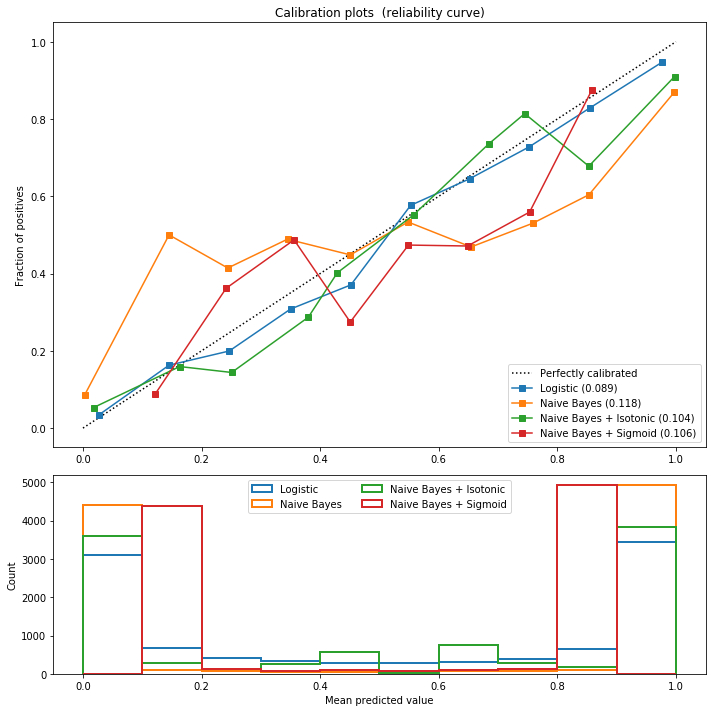

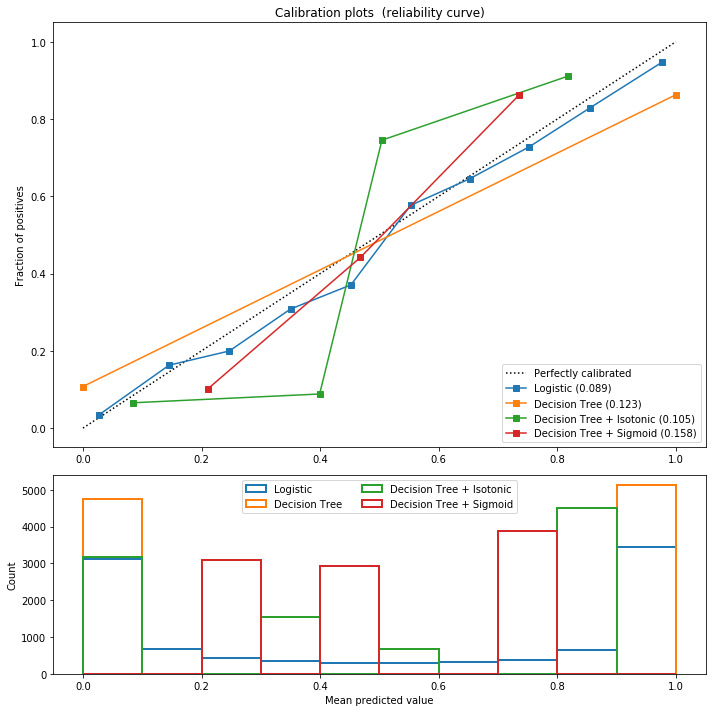

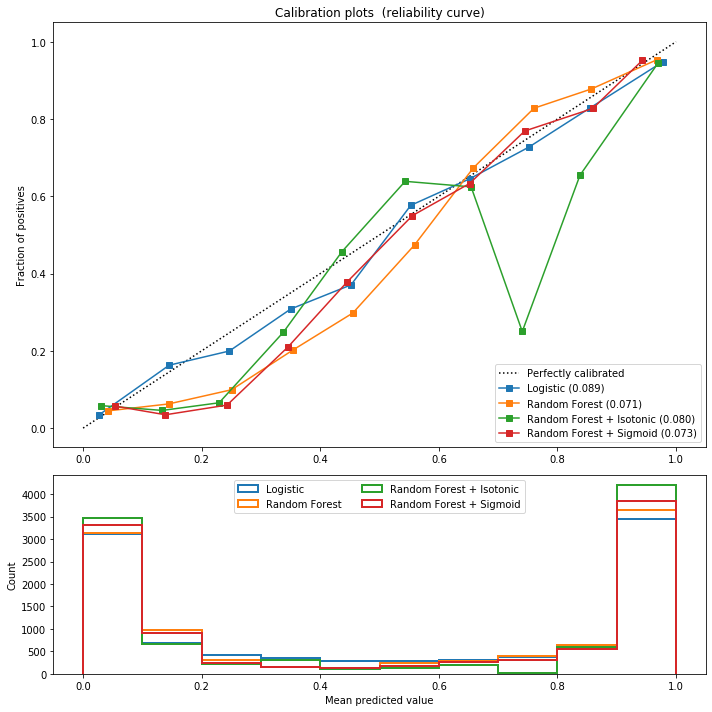

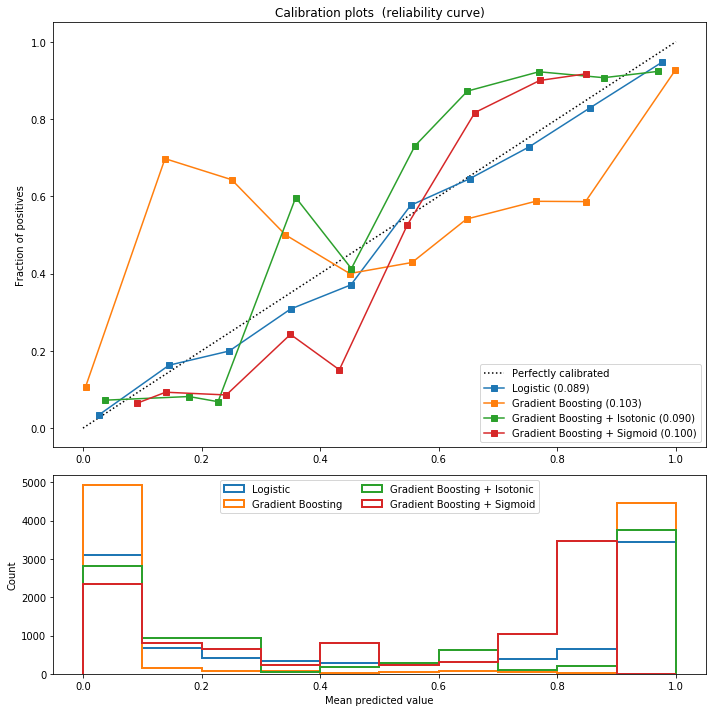

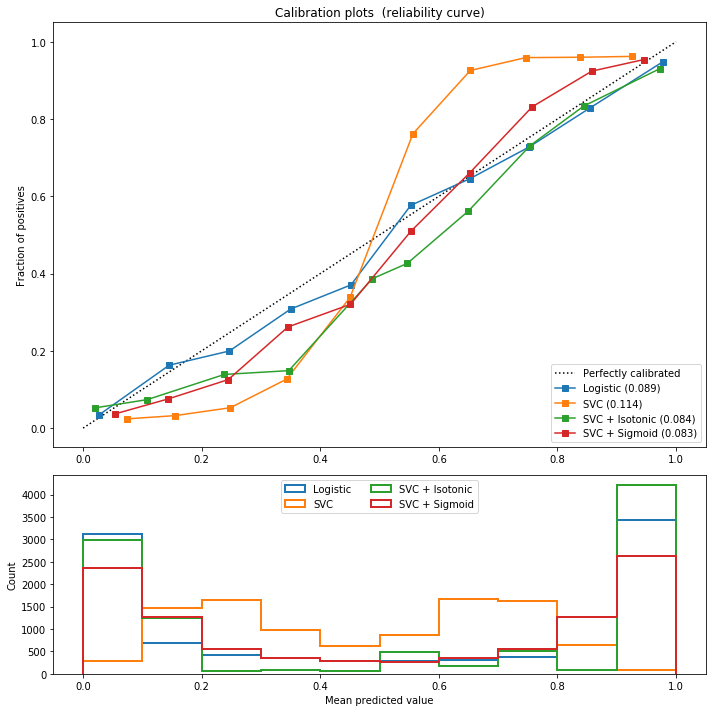

In [8]:
plot_calibration_curve_2(GaussianNB(), "Naive Bayes", 1)
plot_calibration_curve_2(DecisionTreeClassifier(), "Decision Tree", 2)
plot_calibration_curve_2(RandomForestClassifier(), "Random Forest", 3)
plot_calibration_curve_2(GradientBoostingClassifier(), "Gradient Boosting", 4)
plot_calibration_curve_2(SVC(), "SVC", 5)